# How does genre factor into Movie Success
- Also, does genre/success depend on domestic vs abroad?

What datasets will this need?
- IMDB title basics for Genre Info
- TN Movie Budgets for domestic and worldwide gross

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandasql import sqldf

df = pd.read_csv('TN_budget_and_IMDB.csv').drop_duplicates('tconst')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625 entries, 0 to 3839
Data columns (total 8 columns):
movie                3625 non-null object
genres               3625 non-null object
directors            3625 non-null object
writers              3625 non-null object
production_budget    3625 non-null int64
domestic_gross       3625 non-null int64
worldwide_gross      3625 non-null int64
tconst               3625 non-null object
dtypes: int64(3), object(5)
memory usage: 254.9+ KB


In [6]:
df['genres'].value_counts().head(10)

Drama                         465
Documentary                   262
Comedy                        131
Comedy,Drama                  104
Horror                         97
Drama,Romance                  85
Comedy,Drama,Romance           85
Thriller                       83
Adventure,Animation,Comedy     75
Drama,Thriller                 61
Name: genres, dtype: int64

In [3]:
df.describe()

,production_budget,domestic_gross,worldwide_gross
count,3.625000e+03,3.625000e+03,3.625000e+03
mean,3.336453e+07,4.030352e+07,9.492599e+07
std,4.551238e+07,7.128210e+07,1.942271e+08
min,1.400000e+03,0.000000e+00,0.000000e+00
25%,5.000000e+06,4.335880e+05,2.009644e+06
50%,1.700000e+07,1.439410e+07,2.468752e+07
75%,4.000000e+07,4.826558e+07,9.512734e+07
max,4.250000e+08,7.605076e+08,2.776345e+09


Often, movies belong to more than one genre. For the purposes of our data, each movie will count towards every individual genre it belongs to (so Action,Crime,Drama will contribute to Action and Crime and Drama)

In [30]:
new_df = pd.DataFrame(df.genres.str.split(',').tolist(), index=df.tconst).stack()
new_df = new_df.reset_index([0, 'tconst'])
new_df.columns = ['tconst','genre']


q = """SELECT movie, genre, domestic_gross, worldwide_gross
    FROM df
    JOIN new_df
    USING(tconst)
    WHERE (domestic_gross > 0 OR worldwide_gross > 0) AND genre != 'Missing genre data';"""

genres_df = sqldf(q)
genres_df

,movie,genre,domestic_gross,worldwide_gross
0,Foodfight!,Action,0,73706
1,Foodfight!,Animation,0,73706
2,Foodfight!,Comedy,0,73706
3,Mortal Kombat,Action,70433227,122133227
4,Mortal Kombat,Adventure,70433227,122133227
...,...,...,...,...
6926,Sisters,Drama,87044645,106030660
6927,Ali,Drama,58183966,87683966
6928,The Promise,Drama,8224288,10551417
6929,Columbus,Comedy,1017107,1110511


In [31]:
#grouped by genre, median is probably more accurate to actual results
#But I would be interested to see median vs mean
#Is max the same in median and mean? Is there a genre where outliers are more extreme?
groupedavg = genres_df.groupby('genre').mean()
groupedmed = genres_df.groupby('genre').median()

# Next question:
- have plottable data for mean and median, both domestic and worldwide
- Should pick between mean and median. Probably median, cause strong right skew.
- Does mean vs median vary by genre? Do some have more outliers?
- Overthinking: point isn't to cover every possible variable, but to get useful, actionable info
- Focus on question: what genre is most profitable, so focus on median

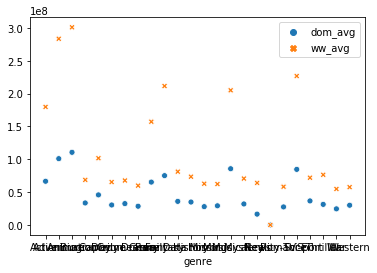

In [13]:
sns.scatterplot(data = groupedavg)

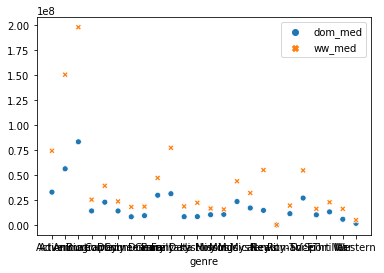

In [22]:
sns.scatterplot(data = groupedmed)

In [32]:
dom_gross = groupedmed.sort_values('domestic_gross',ascending=False).head(9)
dom_gross['domestic_gross'] = dom_gross['domestic_gross'].map(lambda x:x/dom_gross['domestic_gross'].max())

In [33]:
ww_gross = groupedmed.sort_values('worldwide_gross',ascending=False).head(9)
ww_gross['worldwide_gross'] = ww_gross['worldwide_gross'].map(lambda x:x/ww_gross['worldwide_gross'].max())

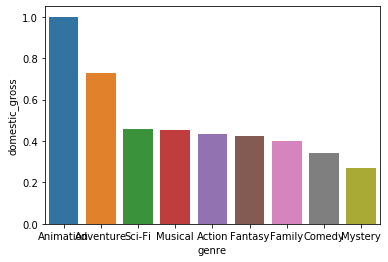

In [34]:
sns.barplot(x = dom_gross.index,y = dom_gross['domestic_gross'])

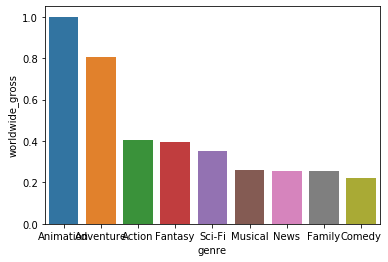

In [35]:
sns.barplot(x = ww_gross.index,y = ww_gross['worldwide_gross'])

In [151]:
q = """SELECT genre, d.domestic_gross, d.worldwide_gross
    FROM dom_gross d
    LEFT JOIN ww_gross w
    USING(genre)
    UNION
    SELECT genre, w.domestic_gross, w.worldwide_gross
    FROM ww_gross w
    LEFT JOIN dom_gross d
    USING(genre);"""

group_results = pd.melt(sqldf(q), id_vars="genre", var_name="location", value_name="value")

In [152]:
group_results

,genre,location,value
0,Action,domestic_gross,36108758.0
1,Adventure,domestic_gross,60522097.0
2,Animation,domestic_gross,73921000.0
3,Comedy,domestic_gross,29910897.0
4,Family,domestic_gross,35287788.0
5,Fantasy,domestic_gross,47225655.0
6,Musical,domestic_gross,84300000.0
7,Mystery,domestic_gross,22510790.5
8,News,domestic_gross,15716828.0
9,Sci-Fi,domestic_gross,34469210.0


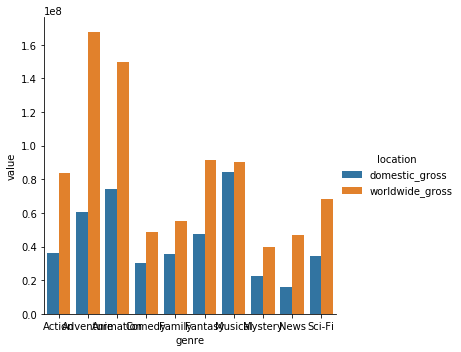

In [159]:
sns.catplot(x='genre',y='value',hue='location',data=group_results,kind='bar')